# Review Text Data Analysis

In [3]:
import pandas as pd
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from gensim.models import CoherenceModel
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from nltk.util import ngrams


#### 1.1 Read review data

In [4]:
df_irvine = pd.read_csv('full_reviews.csv')

#### !!! current problem : too much topic overlapping

#### tried 1)divide data by rating 2) use all data without divide by rating

In [5]:
#select text column by rating == 5 or 4

#text_df_ir=pd.DataFrame(df_irvine[(df_irvine.rating==5 ) | (df_irvine.rating==4)][['text']])
#text_df_ir.info()
#text_df_la=pd.DataFrame(df_la[(df_la.rating==5 ) | (df_la.rating==4)][['text']])
#text_df_la.info()
#text_df_sf=pd.DataFrame(df_sf[(df_la.rating==5 ) | (df_sf.rating==4)][['text']])
#text_df_sf.info()

#text_postive = pd.concat([text_df_ir, text_df_la,text_df_sf], ignore_index=True)

#remove punctuation

df_irvine['text_processed'] = \
df_irvine['text'].map(lambda x: re.sub('[,\.!?]','',x))
#convert the text to lowercase
df_irvine['text_processed'] = \
df_irvine['text_processed'].map(lambda x: x.lower())



#### 1.3 Remove stopwords

In [27]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use'])


irvine_text =df_irvine.text_processed.values.tolist()


#split sentences to words
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
words_irvine = list(sent_to_words(irvine_text))


[nltk_data] Downloading package stopwords to /Users/anni/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:

# Build the bigram and trigram models
bigram = gensim.models.Phrases(words_irvine, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[words_irvine], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [25]:

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]



# remove stop words
data_nonstopwords = remove_stopwords(words_irvine)

# Form Bigrams
data_words_bigrams = make_bigrams(data_nonstopwords)
# Form trigrams
data_words_trigrams = make_trigrams(data_nonstopwords)

## LDA
#### Selva Prabhakaran (2018) Topic Modeling with Gensim (Python) [Source code] https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#15visualizethetopicskeywords

In [12]:
import gensim.corpora as corpora

# Create Dictionary
id2word_irvine = corpora.Dictionary(data_words_bigrams)


# Create Corpus
texts_irvine = data_words_bigrams



# Term Document Frequency
#Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count)
corpus_irvine = [id2word_irvine.doc2bow(text) for text in data_words_bigrams]


### k should be ?

In [13]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus_irvine,
                                           id2word=id2word_irvine,
                                           num_topics=num_topics, 
                                           )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [14]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word_irvine, corpus=corpus_irvine, texts=data_words_bigrams, start=2, limit=20, step=2)

In [15]:
# Plotting tools
import matplotlib.pyplot as plt
%matplotlib inline

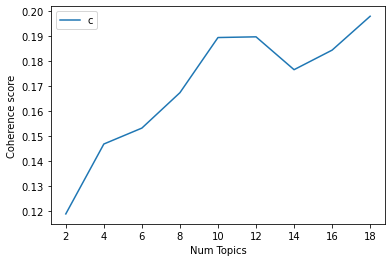

In [16]:
# Show graph
limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
from pprint import pprint

# number of topics
num_topics = 10


# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus_irvine,
                                       id2word=id2word_irvine,
                                       num_topics=num_topics, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())


doc_lda = lda_model[corpus_irvine]


[(0,
  '0.019*"place" + 0.019*"food" + 0.014*"great" + 0.011*"service" + '
  '0.008*"vegan" + 0.008*"nice" + 0.007*"one" + 0.007*"good" + '
  '0.007*"everyone" + 0.007*"experience"'),
 (1,
  '0.013*"food" + 0.009*"place" + 0.008*"came" + 0.008*"like" + 0.007*"love" + '
  '0.007*"great" + 0.007*"drink" + 0.007*"friend" + 0.006*"service" + '
  '0.006*"many"'),
 (2,
  '0.024*"place" + 0.022*"good" + 0.012*"really" + 0.011*"food" + 0.009*"love" '
  '+ 0.009*"get" + 0.009*"spot" + 0.009*"one" + 0.009*"try" + '
  '0.008*"location"'),
 (3,
  '0.027*"great" + 0.019*"time" + 0.019*"food" + 0.018*"service" + '
  '0.012*"place" + 0.011*"good" + 0.010*"order" + 0.009*"best" + 0.008*"back" '
  '+ 0.007*"always"'),
 (4,
  '0.011*"love" + 0.011*"place" + 0.010*"food" + 0.009*"boba" + 0.008*"go" + '
  '0.007*"best" + 0.007*"ordered" + 0.007*"good" + 0.007*"made" + 0.006*"got"'),
 (5,
  '0.022*"place" + 0.019*"food" + 0.013*"service" + 0.011*"good" + '
  '0.010*"quality" + 0.008*"go" + 0.008*"came" + 0

In [22]:
# Compute Perplexity
print('\npostive_Perplexity: ', lda_model.log_perplexity(corpus_irvine))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word_irvine, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)




postive_Perplexity:  -7.983398480613558

Coherence Score:  0.20605134053819757


In [24]:
import pyLDAvis
import pyLDAvis.gensim_models
import pickle 
import os

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus_irvine, id2word_irvine)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared

/Users/anni/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/anni/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/anni/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/anni/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/anni/opt/anaconda3/lib/python3.9/site-

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.062835 -0.045314       1        1  16.158328
3     -0.046477 -0.001472       2        1  14.353135
8     -0.064171  0.001738       3        1  10.715701
5      0.036353 -0.014170       4        1  10.285980
0      0.002119  0.025602       5        1   9.371681
9     -0.051157 -0.089591       6        1   8.546540
4      0.047748  0.103404       7        1   8.251310
1     -0.044127  0.127188       8        1   8.050913
6     -0.000566 -0.073019       9        1   7.834109
7      0.183113 -0.034365      10        1   6.432304, topic_info=          Term        Freq       Total Category  logprob  loglift
221    chicken  177.000000  177.000000  Default  30.0000  30.0000
36   delicious  180.000000  180.000000  Default  29.0000  29.0000
60        food  639.000000  639.000000  Default  28.0000  28.0000
165       boba   55.000000   55.000000  Default  27.0000  27.0000
122   friendly  109.000000  109.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
50       place   13.768875  604.480357  Topic10  -5.2840  -1.0381
8          one   10.830032  236.776683  Topic10  -5.5241  -0.3410
81        made    9.583502  104.828625  Topic10  -5.6464   0.3516
279      every    8.970568   67.125717  Topic10  -5.7125   0.7312
107    service   10.075817  378.262372  Topic10  -5.5963  -0.8816

[778 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
915       3  0.229751     absolute
915       6  0.536086     absolute
915       8  0.076584     absolute
915       9  0.076584     absolute
3650      7  0.923613     addition
...     ...       ...          ...
456       4  0.036475          yes
456      10  0.109426          yes
2195      3  0.303164          yum
2195      4  0.606329          yum
3364      2  0.840427  zion_market

[1866 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 9, 6, 1, 10, 5, 2, 7, 8])